# Color Space Transformations

### Import

In [90]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import spectral.io.aviris as aviris
import matplotlib.tri as mtri
from scipy.spatial.transform import Rotation as rot
from PIL import Image
from scipy import ndimage
from matplotlib import cm
from mpl_toolkits import mplot3d
from skimage import io, color
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Rectangle, Circle, Wedge, Polygon
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal as mnorm
from sklearn.decomposition import PCA

### Fonts

In [91]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Create a 0.5 unit sphere

<br>
Technically, the color space provided by an light-emitting device using RGB is a cube. The three axes of red, green and blue are orthogonal, and each has a range between 0 (completely off) and 1 (maximum intensity). In practice, the light emitting units (LEDs, OLEDs, etc) can only take on a limited range of possible values between 0 and 1. This depends on the bit depth allowed by the device and graphics unit driving it. All the resolution of our screen continues to increase in width and height, color depth has pretty much been the same for a long time, at a 8-bit resolution. 8 bits allows for 256 discrete values of channel intensities. Therefore, an monitor with an 8bit color depth can display 256 x 256 x 256 = 16,7772,1616 different colors, all the possible combinations of the red, green, and blue channel combined. This is pretty good, considering that when I started using computers we went from CGA graphics cards, which allowed for 4 different colors to be displayed, to EGA graphics cards which allowed for 16, and then to VGA graphics cards with a whopping 256 different colors! <br><br>
So, technically, the entire range of colors a monitor can display is in the cube with verices [0,0,0] (completely black) to [1,0,0] (red) to [1,1,0] (yellow), all the way up to [1,1,1] which is white at maximum strength. This is known as the gamut of your monitor. When we use color to explore subspace, dimensionality reduction and manifolds (next chapter in the course), we will explore ways of applying transformations to entire sets of points. The problem of using the entire gamut in this case, is that almost all transformations will have use move points (e.g. the RGB values of pixels in an image) to outside this cube, unless we are contracting or compression the points towards the center of the cube. Imagine it this way: you are holding a perfect cube in your hand. Take note of the exact cube of space it occupies. Now, try moving the cube, either by rotating or translating it. No matter what you do (unless you do perfect rotation of 90, 180 or 270 degrees) some bit of the cube will now be outside that original space it occupied. That means that the monitor on which the cube was based cannot produce that color. Because outside of the original space, values become larger than the maximum strength, or smaller than the minimum strength (which is already 0). You can see that in the figure below. <br><br>
To prevent this from happening, we therefore restrict ourselves to a sphere within the cube, and more specifically, half a unit-sphere. In a unit sphere, each point is exactly at distance 1 of the origin, meaning it is perfectly contained within the cube. By making it even smaller (half of that, so distance = 0.5) we give ourselves some space to move, scale, shear or rotate points without risking having them move outside of the monitors gamut. 


### Load Isosphere OBJ files for visualization purposes

In [171]:
vertices = []
faces = []
with open('../../data/color/meshes/isosphere_lowres.obj','r') as f:
    for line in f:
        if ('v ') in line[:2]:
            elements = line.rstrip().split(' ')[1:]
            elements = np.array(elements).astype(float)
            vertices.append(elements)
            
        if ('f ') in line[:2]:
            elements = line.rstrip().split(' ')[1:]
            elements = '/'.join(elements)
            elements = elements.split('/')
            elements = np.array(elements).astype(int)
            face = elements[::3].tolist()
            faces.append(face)
faces = np.array(faces) - 1
vertices = np.array(vertices)
colors = vertices + 1
colors = colors / 2

### Draw Sphere

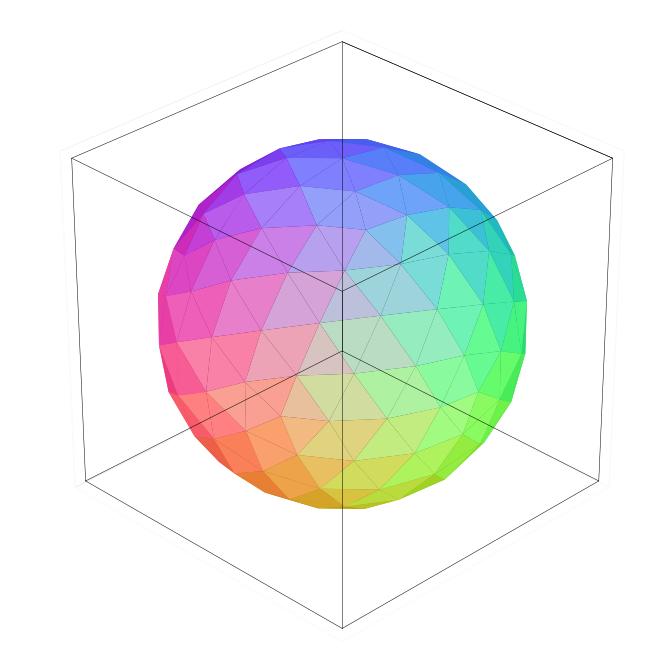

In [175]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for i in range(faces.shape[0]):
    face = faces[i,:]
    v1 = vertices[face[0],:]
    v2 = vertices[face[1],:]
    v3 = vertices[face[2],:]
    vc1 = colors[face[0],:]
    vc2 = colors[face[0],:]
    vc3 = colors[face[0],:]
    C = np.vstack((vc1,vc2,vc3))
    C = np.mean(C,axis=0)
    V = np.vstack((v1,v2,v3))
    Vt = [list(zip(V[:,0],V[:,1],V[:,2]))]
    poly = Poly3DCollection(Vt,facecolor=C,alpha=1.0)
    ax.add_collection3d(poly)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.set_box_aspect((np.ptp(vertices[:,0]), 
                   np.ptp(vertices[:,1]), 
                   np.ptp(vertices[:,2])))
ax.scatter(-1,-1,1,color=(0,0,1),edgecolors='k',s=200)
ax.scatter(-1,1,-1,color=(0,1,0),edgecolors='k',s=200)
ax.scatter(1,-1,-1,color=(1,0,0),edgecolors='k',s=200)


ax.plot3D([-1,-1],[-1,-1],[-1,1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([-1,-1],[-1,1],[-1,-1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([-1,1],[-1,-1],[-1,-1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([1,-1],[1,1],[1,1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([1,1],[1,1],[1,-1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([-1,-1],[1,1],[-1,1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([-1,-1],[-1,1],[1,1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([-1,-1],[-1,1],[1,1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([1,1],[1,-1],[1,1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([1,-1],[-1,-1],[1,1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([1,1],[-1,1],[-1,-1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([1,1],[-1,-1],[-1,1],c='k',linewidth=0.5,zorder=1000);
ax.plot3D([-1,1],[1,1],[-1,-1],c='k',linewidth=0.5,zorder=1000);
ax.axes.xaxis.set_ticks([],c='w')
ax.axes.yaxis.set_ticks([])
ax.axes.zaxis.set_ticks([])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.w_xaxis.line.set_color((1,1,1))
ax.w_yaxis.line.set_color((1,1,1))
ax.w_zaxis.line.set_color((1,1,1))
ax.view_init(elev=30, azim=45)
plt.savefig('../../assets/matplotlib/018_RGBspace_1.png',dpi=300,bbox_inches="tight")

### Visualize Sphere

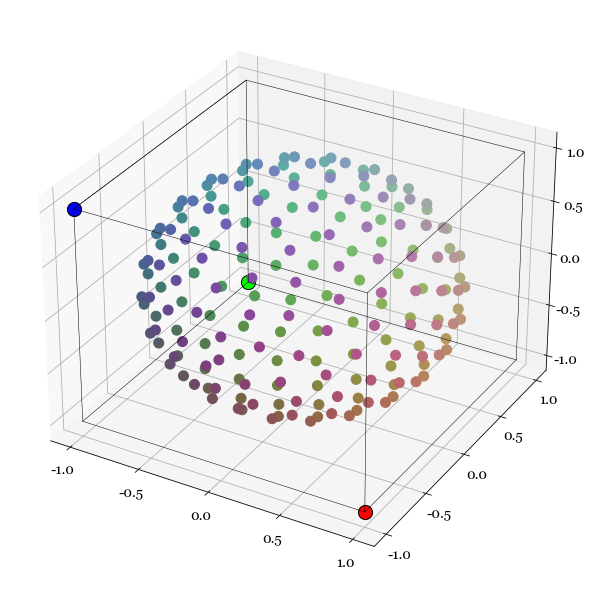

In [62]:
skip = 1
plt.figure(figsize=(12,8))
plt.subplots_adjust(left=0.0,bottom=0.0, right=1.0, top=1.0, wspace=0., hspace=0.1)
ax = plt.axes(projection='3d')
ax.scatter(S[:,0],S[:,1],S[:,2],c=C,alpha=1.0,s=100,zorder=3000)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_yticks(np.linspace(-1,1,5),labels=np.linspace(-1,1,5),fontsize=14,**csfont);
ax.set_xticks(np.linspace(-1,1,5),labels=np.linspace(-1,1,5),fontsize=14,**csfont);
ax.set_zticks(np.linspace(-1,1,5),labels=np.linspace(-1,1,5),fontsize=14,**csfont);


# ax.text(0.0,0.1,0.1,'(0,0,0)',fontsize=28,**csfont);
# ax.text(1.40,0.1,0.1,'Red',fontsize=28,**csfont);
# ax.text(0.0,1.15,0.0,'Green',fontsize=28,**csfont);
# ax.text(0.0,0,1.25,'Blue',fontsize=28,**csfont);



# ax.plot3D([0,0],[0,0],[0,-1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([1,1],[0,0],[0,-1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,0],[1,1],[0,-1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([1,1],[1,1],[0,-1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,0],[0,-1],[0,0],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([1,1],[0,-1],[0,0],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,0],[0,-1],[1,1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([1,1],[0,-1],[1,1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,-1],[0,0],[0,0],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,-1],[0,0],[1,1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,-1],[1,1],[0,0],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,-1],[1,1],[1,1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);


# res = 21
# X = np.linspace(0,1,res)
# Y = np.linspace(0,1,res)
# X, Y = np.meshgrid(X, Y)
# Z = np.zeros((res,res))
# C = np.zeros((res,res,3))
# D = np.sqrt((X-0.5)**2 + (Y-0.5)**2)


# C[:,:,0] = X
# C[:,:,1] = Y
# C[:,:,2] = Z


# xg,yg = np.where(D>0.5)
# C[xg,yg,0] = 1.0
# C[xg,yg,1] = 1.0
# C[xg,yg,2] = 1.0
# # C[:5,:5,0]
# # # C[:,:,1] = X
# # # C[:,:,2] = Y

# ax.set_aspect('auto')
# # ax.set_box_aspect([1,1,1])
# ax.imshow(C)


# # surf = ax.plot_surface(Z-1, Y, X, rstride=1, cstride=1, edgecolors='k',
# #                        facecolors=C,linewidth=0.5, antialiased=False,shade=False)

# # C[:,:,0] = X
# # C[:,:,1] = Y
# # C[:,:,2] = Z
# # C[xg,yg,0] = 1.0
# # C[xg,yg,1] = 1.0
# # C[xg,yg,2] = 1.0

# # surf = ax.plot_surface(X, Y, Z-1, rstride=1, cstride=1, edgecolors='k',
# #                        facecolors=C,linewidth=0.5, antialiased=False,shade=False)

# # C[:,:,0] = X
# # C[:,:,1] = Z
# # C[:,:,2] = Y
# # C[xg,yg,0] = 1.0
# # C[xg,yg,1] = 1.0
# # C[xg,yg,2] = 1.0

# # surf = ax.plot_surface(X, Z-1 ,Y,rstride=1, cstride=1, edgecolors='k',
# #                        facecolors=C,linewidth=0.5, antialiased=False,shade=False)



### Create the Transformation matrices

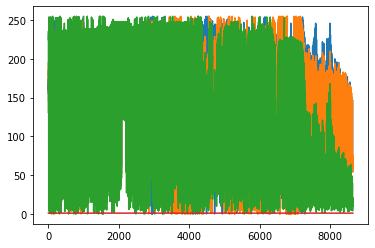

In [51]:
# #Translation
# T = np.eye(4)
# T[3,0] = -10
# T[3,1] = -10
# T[3,2] = 10

# v1trans = np.dot(v1,T)[:,:-1]
# plt.plot(v1[::100,:])



# v1trans[v1trans>255] = 255
# v1trans[v1trans<0] = 0

# im1trans = np.reshape(v1trans,(im1.shape[0],im1.shape[1],3))
# # im1trans = im1trans.astype('uint')
# # im1trans[im1trans>255] = 255
# # im1trans[im1trans<0] = 0

# # plt.figure(figsize=(12,12))
# # plt.subplots_adjust(left=0.0,bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.1)
# # plt.subplot(2,1,1)
# # plt.imshow(im1)
# # plt.axis('off')
# # plt.subplot(2,1,2)
# # plt.imshow(im1trans)
# # plt.axis('off')
# # # #Rotation
# # # R = np.eye(4)
# # # r = rot.from_euler('x', 45, degrees=True)
# # # # r = rot.from_quat([np.sin(np.pi/2), np.cos(np.pi/8), -np.sin(np.pi/4), np.cos(np.pi/4)])
# # # r = r.as_matrix()
# # # R[:-1,:-1] = r
# # # BR = np.dot(B,R)
# # # AR = np.dot(A,R)
# # # CR = np.cov(BR[:,:2].T)
# # # CR = CR * (1/(var**2))

# # # #Scaling
# # # SC = np.eye(4)
# # # SC[0,0] = 1
# # # SC[1,1] = 2
# # # SC[2,2] = 0.5
# # # BSC = np.dot(B,SC)
# # # ASC = np.dot(A,SC)
# # # CSC = np.cov(BSC[:,:2].T)
# # # CSC = CSC * (1/(var**2))

# # # #Shearing
# # # SH = np.eye(4)
# # # SH[1,0] = +2.0
# # # SH[0,1] = -0.5
# # # SH[2,2] = -0.50
# # # SH[3,3] = 0.25
# # # BSH = np.dot(B,SH)
# # # ASH = np.dot(A,SH)
# # # CSH = np.cov(BSH[:,:2].T)
# # # CSH = CSH * (1/(var**2))

# # # #Rotation and Scaling
# # # RS = np.dot(SC,R)
# # # BRS = np.dot(B,RS)
# # # ARS = np.dot(A,RS)
# # # CRS = np.cov(BRS[:,:2].T)
# # # CRS = CRS * (1/(var**2))

# # # AxesList = [AI,AT,AR,ASC,ASH,ARS]
# # # CovList = [CI,CT,CR,CSC,CSH,CRS]
# # # Transformedlist = [BI,BT,BR,BSC,BSH,BRS]

# # # # # plot_matrices(B,I,BI,A,AI,CI,'Identity')
# # # # # plot_matrices(B,T,BT,A,AT,CT,'Transformation')
# # # # # plot_matrices(B,R,BR,A,AR,CR,'Rotation')
# # # # # plot_matrices(B,SC,BSC,A,ASC,CSC,'Scaling')
# # # # # plot_matrices(B,SH,BSH,A,ASH,CSH,'Shearing')
# # # # # plot_matrices(B,RS,BRS,A,ARS,CRS,'Rotation + Scaling')

### Look at the change in our axes

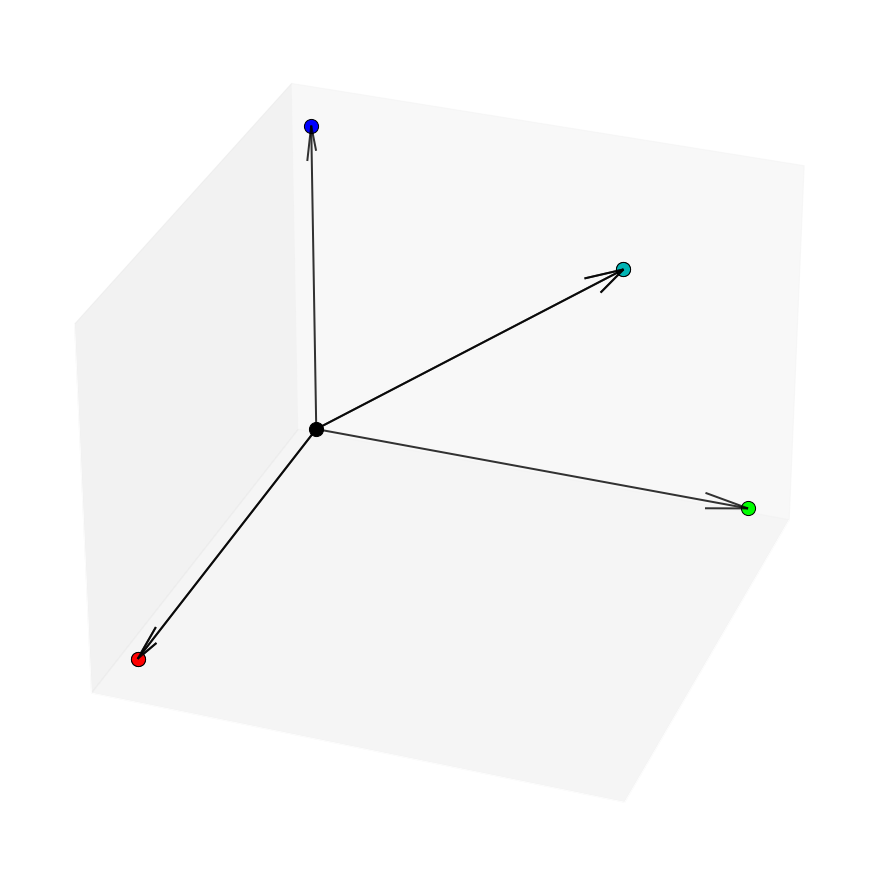

In [7]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(left=0.0,bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.1)
ax = plt.axes(projection='3d')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_yticks(np.linspace(0,1,5),labels=np.linspace(0,1,5),fontsize=14,**csfont);
ax.set_xticks(np.linspace(0,1,5),labels=np.linspace(0,1,5),fontsize=14,**csfont);
ax.set_zticks(np.linspace(0,1,5),labels=np.linspace(0,1,5),fontsize=14,**csfont);

AR

ax.scatter(0,0,1,color=(0,0,1),edgecolors='k',s=200)
ax.scatter(0,1,0,color=(0,1,0),edgecolors='k',s=200)
ax.scatter(1,0,0,color=(1,0,0),edgecolors='k',s=200)
ax.quiver(0,0,0,1,0,0,color = 'black', alpha = .8, lw = 2, arrow_length_ratio = 0.1)
ax.quiver(0,0,0,0,1,0,color = 'black', alpha = .8, lw = 2, arrow_length_ratio = 0.1)
ax.quiver(0,0,0,0,0,1,color = 'black', alpha = .8, lw = 2, arrow_length_ratio = 0.1)


# AR = np.abs(AR)

# ax.scatter(0,0,0,color=(0,0,0),edgecolors='k',s=200)
# ax.scatter(AR[0,0],AR[0,1],AR[0,2],color=(AR[0,0],AR[0,1],AR[0,2]),edgecolors='k',s=200)
# ax.scatter(AR[1,0],AR[1,1],AR[1,2],color=(AR[1,0],AR[1,1],AR[1,2]),edgecolors='k',s=200)
# ax.scatter(AR[2,0],AR[2,1],AR[2,2],color=(AR[2,0],AR[2,1],AR[2,2]),edgecolors='k',s=200)
# ax.quiver(0,0,0,AR[0,0],AR[0,1],AR[0,2],color = 'black', alpha = .8, lw = 2, arrow_length_ratio = 0.1)
# ax.quiver(0,0,0,AR[1,0],AR[1,1],AR[1,2],color = 'black', alpha = .8, lw = 2, arrow_length_ratio = 0.1)
# ax.quiver(0,0,0,AR[2,0],AR[2,1],AR[2,2],color = 'black', alpha = .8, lw = 2, arrow_length_ratio = 0.1)


# ax.text(0.0,0.1,0.1,'(0,0,0)',fontsize=28,**csfont);
# ax.text(1.40,0.1,0.1,'Red',fontsize=28,**csfont);
# ax.text(0.0,1.15,0.0,'Green',fontsize=28,**csfont);
# ax.text(0.0,0,1.25,'Blue',fontsize=28,**csfont);

# ax.plot3D([0,0],[0,0],[0,1],c='k',linewidth=3,zorder=1000);
# ax.plot3D([0,0],[0,1],[0,0],c='k',linewidth=3,zorder=1000);
# ax.plot3D([0,1],[0,0],[0,0],c='k',linewidth=3,zorder=1000);
# ax.plot3D([1,0],[1,1],[1,1],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([1,1],[1,1],[1,0],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([0,0],[1,1],[0,1],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([0,0],[0,1],[1,1],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([0,0],[0,1],[1,1],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([1,1],[1,0],[1,1],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([1,0],[0,0],[1,1],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([1,1],[0,1],[0,0],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([1,1],[0,0],[0,1],c='k',linewidth=0.5,zorder=1000);
# ax.plot3D([0,1],[1,1],[0,0],c='k',linewidth=0.5,zorder=1000);


# ax.plot3D([0,0],[0,0],[0,-1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([1,1],[0,0],[0,-1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,0],[1,1],[0,-1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([1,1],[1,1],[0,-1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,0],[0,-1],[0,0],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([1,1],[0,-1],[0,0],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,0],[0,-1],[1,1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([1,1],[0,-1],[1,1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,-1],[0,0],[0,0],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,-1],[0,0],[1,1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,-1],[1,1],[0,0],c='k',linewidth=1,dashes=[8, 4],zorder=1000);
# ax.plot3D([0,-1],[1,1],[1,1],c='k',linewidth=1,dashes=[8, 4],zorder=1000);


# res = 51
# X = np.linspace(0,1,res)
# Y = np.linspace(0,1,res)
# X, Y = np.meshgrid(X, Y)
# Z = np.zeros((res,res))
# C = np.zeros((res,res,3))

# C[:,:,0] = Z
# C[:,:,1] = X
# C[:,:,2] = Y
# surf = ax.plot_surface(Z-1, Y, X, rstride=1, cstride=1, edgecolors='k',
#                        facecolors=C,linewidth=0.5, antialiased=False,shade=False)

# C[:,:,0] = X
# C[:,:,1] = Y
# C[:,:,2] = Z
# surf = ax.plot_surface(X, Y, Z-1, rstride=1, cstride=1, edgecolors='k',
#                        facecolors=C,linewidth=0.5, antialiased=False,shade=False)

# C[:,:,0] = X
# C[:,:,1] = Z
# C[:,:,2] = Y
# surf = ax.plot_surface(X, Z-1 ,Y,rstride=1, cstride=1, edgecolors='k',
#                        facecolors=C,linewidth=0.5, antialiased=False,shade=False)

ax.axes.xaxis.set_ticks([],c='w')
ax.axes.yaxis.set_ticks([])
ax.axes.zaxis.set_ticks([])
# ax.xaxis.pane.fill = False
# ax.yaxis.pane.fill = False
# ax.zaxis.pane.fill = False
ax.w_xaxis.line.set_color((1,1,1))
ax.w_yaxis.line.set_color((1,1,1))
ax.w_zaxis.line.set_color((1,1,1))
ax.view_init(elev=30, azim=20)
# plt.savefig('../../assets/matplotlib/018_RGBspace_eigenvectors.png',dpi=300,bbox_inches="tight")

# Method one: Use numpy's eig function
The compute the eigenvalues and eigenvectors using the eig function, we first have to center the matrix at 0 and compute the covariance matrix. It is the covariance matrix the 'eig' function uses to compute the eigenvectors and eigenvalues. in the SVD function, as well as in scikit-learn's PCA function this is done internally. When you look at the eigenvalues, you will notice that the largest value is actually the second entry, meaning that the second eigenvector explains most of the data. Again, the other two algorithms will sort the eigenvectors so that they are in descending order of eigenvalue. This means that later eigenvectors explain less and less variance. Plotting the eigenvalues derived from your data gives you a good sense of what dimensions to keep and which to discard, particularly when the dimensionality of your data is high. Here, we only have two dimensions, so relatively little to work with. Later, we will run PCA on a much larger data set. 

In [ ]:
matrices = [BI,BT,BR,BSC,BSH,BRS]
eigenvals_list = []
eigenvector_list = []
for M in matrices:
    centered_matrix = M.T - M.T.mean(axis=1)[:, np.newaxis]
    cov = np.dot(centered_matrix, centered_matrix.T)
    eigvals, eigvecs = np.linalg.eig(cov)
    eigval1 = eigvals[0] 
    eigval2 = eigvals[1]
    eigvector1 = eigvecs[:,0]
    eigvector2 = eigvecs[:,1]
#     eigvals = eigvals / np.linalg.norm(eigvals)
    eigvals = eigvals / M.shape[0] * 2
    eigenvals_list.append(eigvals)
    eigenvector_list.append(eigvecs)    

### Plot the Eigenvectors
The two yellow arrows are the eigenvectors. They are unit length (length=1), so they tell us the direction two orthogonal axis that were computed, but not how much variance each axis explains. This information is captured by the eigenvalues. Scaling the two eigenvectors by the respective eigenvalues creates the orange arrows that clear reveal one of the eigenvectors (2 in this case, because 'eig' doesn't sort our eigenvectors based on eigenvalues) is clearly explaining the majority of the variance observed. Given the domain of our data, it is hard to visualize the eigenvalues with their original value, as they are too large, so I have scaled them a bit for visualization purposes.

In [ ]:
xtick = np.linspace(-2,2,5)
ytick = np.linspace(-2,2,5)
xticklabels = np.linspace(-2,2,5)
yticklabels = np.linspace(-2,2,5)

plt.figure(figsize=(12,8))
plt.subplots_adjust(left=0.0,bottom=0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

AxesList = [AI,AT,AR,ASC,ASH,ARS]
CovList = [CI,CT,CR,CSC,CSH,CRS]
Transformedlist = [BI,BT,BR,BSC,BSH,BRS]

for g in range(len(AxesList)):
    AM = AxesList[g]
    EV = eigenvals_list[g]
    EM = eigenvector_list[g].T    
    BM = Transformedlist[g]
    ax = plt.subplot(2,3,g+1)
    ax.set_aspect('equal', adjustable='box')
    plt.scatter(BM[::1000,0],BM[::1000,1],linewidth=0.5,s=60,color=(0.8,0.8,0.8))
    plt.axis((-2,2,-2,2));
    plt.grid();
    plt.xlabel('x',fontsize=28,**csfont);
    plt.ylabel('y',fontsize=28,**csfont);
    plt.xticks(xtick,xticklabels,fontsize=20,**csfont);
    plt.yticks(ytick,yticklabels,fontsize=20,**csfont);
    plt.arrow(AM[0,0],AM[0,1],AM[1,0]-AM[0,0],AM[1,1]-AM[0,1],edgecolor=(0,0,0),linewidth=0.5,facecolor=(0.3,0.6,0.9),
              width = 0.05,head_width = 6*0.05,head_length = 6*0.05,
              length_includes_head = True,zorder=1000);
    plt.arrow(AM[0,0],AM[0,1],AM[2,0]-AM[0,0],AM[2,1]-AM[0,1],edgecolor=(0,0,0),linewidth=0.5,facecolor=(0.3,0.6,0.9),
              width = 0.05,head_width = 6*0.05,head_length = 6*0.05,
              length_includes_head = True,zorder=1000);    
    plt.arrow(0,0,EM[0,0]*EV[0],EM[0,1]*EV[0],edgecolor=(0,0,0),linewidth=0.5,facecolor=(0.9,0.9,0.3),
              width = 0.05,head_width = 6*0.05,head_length = 6*0.05,
              length_includes_head = True,zorder=1000);
    plt.arrow(0,0,EM[1,0]*EV[1],EM[1,1]*EV[1],edgecolor=(0,0,0),linewidth=0.5,facecolor=(0.9,0.9,0.3),
              width = 0.05,head_width = 6*0.05,head_length = 6*0.05,
              length_includes_head = True,zorder=1000);


# Method two: Use numpy's SVD function

Numpys SVD function internally uses the eig function but add some extra useful functionality and processing. For example, the eigenvectors are sorted based on their outputs, and the original matrix X is decomposed into three seperate matrices that when applied in sequence together reconstruct our data set X:

### $$X = U \Sigma V^*$$

We image data our data X in the synthetic example data used in this notebook, or any kind of data to which we want to apply dimensionality reduction is some transformation of the same points whose mean and variance are equal across dimensions, and furthermore show no covariance. In other words, the points are all within a perfectly round unit circle (in the case of 2 dimensions like the data used in this notebook, a perfectly round sphere in the case of 3 dimensions, and a perfectly 'round' hypersphere of n dimensions.

### Run the SVD
After running SVD, we can extract the eigenvectors and eigenvalues from the matrices produced by SVD
The eigenvalues can be obtained from S. However, in SVD, these values in S represent singular values, not eigenvalues. Luckily, they are related by squaring: <br> 

## $$eigen value = singular value^2$$

<br>
in matrix S. Unlike the 'eig' function, these are now sorted based on the amount of variance they explain. The eigenvectors are in V. The final matrix U is the final transformation matrix we need to reproduce our data X had we had started with our data being perfectly homogenous (equal variance and means) and with no covariance. This matrix U is a diagonal matrix transformation matrix, meaning that all off-diagonal values are 0. This, in turn allows U to scale each individual data point by some number, but it can't rotate, translate or shear the points relative to the origin. The rotation is build into the eigenvectors in V, whereas the scaling off each axis is represented by the eigenvalues in S. This entire process is invertable, something build into the PCA method provided by scikit-learn, but also something that is easily implemented here with the SVD matrices produced. The image linked here is a perfect visual of how all these matrices are ultimately linked

In [ ]:
[U,S,V] = np.linalg.svd(BR)
svd_eigval1 = S[0]**2
svd_eigval2 = S[1]**2
svd_eigvector1 = V[:,0]
svd_eigvector2 = V[:,1]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(U,cmap='gray',extent=(0,U.shape[0],0,U.shape[0]));
plt.title('U\n',fontsize=32,**csfont)
plt.xticks(np.linspace(0,U.shape[0],5),fontsize=18,**csfont)
plt.yticks(np.linspace(0,U.shape[0],5),fontsize=18,**csfont)
plt.xlabel('m',fontsize=24,**csfont)
plt.ylabel('m',fontsize=24,**csfont)

plt.subplot(1,3,2)
sigma = np.expand_dims(S,-1)
plt.imshow(sigma.T,cmap='gray')
plt.title('Sigma\n',fontsize=32,**csfont)
plt.yticks([])
plt.xticks([0,1],fontsize=18,**csfont)
plt.ylabel('1',fontsize=24,**csfont)
plt.xlabel('n',fontsize=24,**csfont)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(1,3,3);
plt.imshow(V,cmap='gray');
plt.title('V\n',fontsize=32,**csfont);
plt.xticks([0,1],fontsize=18,**csfont);
plt.yticks([0,1],fontsize=18,**csfont);
plt.xlabel('n',fontsize=24,**csfont);
plt.ylabel('n',fontsize=24,**csfont);

### Plotting the scaled eigenvectors once more
Combining S with V gives us the result we already obtained before

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.contour(pdf,extent=(-8,8,-8,8),colors='k',linewidths=0.5,zorder=0,levels=np.linspace(0.0,np.max(pdf),11))
plt.scatter(X[:,0],X[:,1],color=(1,0,0),zorder=100,alpha=1)
plt.arrow(0,0,svd_eigvector1[0],svd_eigvector1[1],
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.arrow(0,0,svd_eigvector2[0],svd_eigvector2[1],
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.axis((-3,3,-3,3))
plt.grid()
plt.xlabel('x',fontsize=28,**csfont);
plt.ylabel('y',fontsize=28,**csfont);
plt.xticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);
plt.yticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);


plt.subplot(1,2,2)
plt.contour(pdf,extent=(-8,8,-8,8),colors='k',linewidths=0.5,zorder=0,levels=np.linspace(0.0,np.max(pdf),11))
plt.scatter(X[:,0],X[:,1],color=(1,0,0),zorder=100,alpha=1)
plt.arrow(0,0,svd_eigvector1[0]*svd_eigval1*0.008,svd_eigvector1[1]*svd_eigval1*0.008,
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*2*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.arrow(0,0,eigvector2[0]*svd_eigval2*0.008,eigvector2[1]*svd_eigval2*0.008,
          width = 0.05,
          length_includes_head = True,
          head_width = 5*0.05,
          head_length = 1.5*3*0.05,
          head_starts_at_zero = False,
          color = 'k',
          zorder=300)
plt.axis((-3,3,-3,3))
plt.grid()
plt.xlabel('x',fontsize=28,**csfont);
plt.ylabel('y',fontsize=28,**csfont);
plt.xticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);
plt.yticks(xtick,labels=xtick.astype(int),fontsize=18,**csfont);

# PCA
PCA adds one more step to this entire process by constructing a space in which the new dimensions are 1) all orthogonal to each other and 2) the amount of variance explained by each subsequent dimension decreases. This makes it easy for us to decide where to cutoff any additional dimensions. For example, we can use a criteria that we keep only the first n components that together explain at least 95% of the data. For large and correlated data sets, this elimates many dimensions already. After our synthetic data, we can will have a look at a larger synthetic data set that demonstrates this. For now, let's see what PCA (in this case the implementation provided by scikit-learn) has to offer and how it relates to what we already have done

### Scikit-learn PCA
These two lines is all you need to do PCA using scikit learzn

In [ ]:
pca = PCA(n_components=2);
C = pca.fit_transform(X);

### Obtained values